# Trends in Fishing Effort Related to El Niño Events Using AIS Data from Global Fishing Watch.


## Authors
- Jessica French 
  jfrench@bren.ucsb.edu
  
- Javier Patrón 
  jpatron@ucsb.edu

- Pol Carbó Mestre
  pcarbomestre@ucsb.edu

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Data I/O](#io)

[4. Metadata Display and Basic Visualization](#display)

[5. Use Case Examples](#usecases)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
### Notebook Purpose

The purpose of this notebook is to explore Global Fishing Watch's dataset showing daily fishing effort as inferred fishing hours daily. This notebook will show how to read in the dataset, visualize the data using google earth engine, and give an overview of how the data can be used to explore changes in fishing effort relative to ENSO events. 


<a id='overview'></a> 
### Dataset Description

The Global Fishing Watch (GFW) provides an open platform to access automatic identification system (AIS) data from commercial fishing activities. The AIS is a tracking system that uses transceivers on ships to broadcast vessel information such as unique identification, position, course, and speed. AIS is integrated into all classes of vessels as a collision avoidance tool. However, the GFW collects and processes raw AIS data related to fishing activities to improve records and assing additional information, such as the distance from shore, depth, etc. Then, with the use of machine learning models, they characterize vessels and fishing activities, which constitute some of the products available in their [API](https://globalfishingwatch.org/our-apis/documentation#introduction).

Pre-processed AIS data can be accessed from their [R package "gfwr"](https://github.com/GlobalFishingWatch/gfwr) or downloaded from their [website](https://globalfishingwatch.org/data-download/) as .cvs files. For this project, we will use some of their existing products related to fishing effort. The data can be accessed from [Google Big Query](https://globalfishingwatch.org/data/our-data-in-bigquery/) in a less processed format and through Google Earth Engine (GEE) for two data subproducts [daily fishing hours](https://developers.google.com/earth-engine/datasets/catalog/GFW_GFF_V1_fishing_hours) and [daily vessel hours](https://developers.google.com/earth-engine/datasets/catalog/GFW_GFF_V1_vessel_hours#image-properties). For accessibility reasons, we will focus on the GEE data.

Each image in the collection contains daily rasters of fishing effort measured in hours of inferred fishing activity per square kilometer. Data is available for a given flag state and day, over a 5 years period (2012-2017), with one band for the fishing activity of each of the following gear types:

- Drifting longlines
- Fixed gear
- Other fishing
- Purse seines
- Squid jigger
- Trawlers

The data belongs to the [first global assessment of commercial fishing activity](https://www.science.org/doi/full/10.1126/science.aao5646), published in Science by GFW (2018). 

<a id='io'></a> 
### Dataset Input/Output 

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Authenticate google earth engine
#ee.Authenticate()

In [2]:
# Initialize google earth engine 
ee.Initialize()

In [3]:
# read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')
# read in data on total vessel hours from google earth engine
dataset2 = ee.ImageCollection('GFW/GFF/V1/vessel_hours')

El Niño events can be identified using the Ocean Niño Index or ONI. The ONI index is a 3 month running mean of ERSST.v5 SST anomalies in the Niño 3.4 region (5 degrees North and South of the equator and between 120 and 170 degrees West). More information is available here.  https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

All of 2015 was above the threshhold of an El Niño event so we will focus on that time period for now. 

In [4]:
# Filter data to El Niño in 2015. 
elnino_data = dataset.filter(ee.Filter.date('2015-01-01', '2016-01-01'))

# Filter data to normal year 2013. 
normal_data = dataset.filter(ee.Filter.date('2013-01-01', '2014-01-01'))

Two of the largest fishing ports in Peru are Paita and Callao. We will create a polygon that encompasses both and set that as our area of interest.

In [5]:
# Define area of interest off the coast of Peru.
roi = ee.Geometry.Polygon([[-84.997101, -12.93982],
      [-84.997101, -3.79797],
      [-76.295929, -3.79797],
      [-76.295929, -12.93982],
      [-84.997101, -12.93982]])

#roi.getInfo()

In [6]:
#visualization parameters for figure 1. 
trawlersVis = {
  'min': 0.0,
  'max': 5.0,
  'palette': ['0d0887', '3d049b', '6903a5', '8d0fa1', 'ae2891', 'cb4679', 'df6363',
  'f0844c', 'faa638', 'fbcc27', 'f0f921']
}

# Viz parameters for figure 2
trawlersVis2 = {
  'palette': ['0C276C', '3B9088', 'EEFF00', 'ffffff']
}


<a id='display'></a> 
### Metadata Display and Basic Visualization

#### Metadata Display

In [7]:
# Define function to view bands of data.
def get_image_ids(gee_snipet):
  x = ee.ImageCollection(gee_snipet)
  first_image = x.first()
  bands_list = first_image.bandNames()
  lista = bands_list.getInfo()
  for i, val in enumerate(lista):
    print(i,val)

In [9]:
# Extract the first image so we can look at info about the data in general. 
image_test = dataset.first()
info = image_test.getInfo()
print(info)
    
# Bands in dataset
print(get_image_ids('GFW/GFF/V1/fishing_hours'))


{'type': 'Image', 'bands': [{'id': 'drifting_longlines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'fixed_gear', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'other_fishing', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'purse_seines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'squid_jigger', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'trawlers', 'data_type': {'type': 'PixelType', 'precision': 

In [10]:
# Show metadata
image_test = dataset2.first()
info = image_test.getInfo()
print(info)

#Show bands in dataset
print(get_image_ids('GFW/GFF/V1/vessel_hours'))

{'type': 'Image', 'bands': [{'id': 'drifting_longlines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'fixed_gear', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'other_fishing', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'purse_seines', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'squid_jigger', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [36000, 16500], 'crs': 'EPSG:4326', 'crs_transform': [0.01, 0, -180, 0, -0.01, 85]}, {'id': 'trawlers', 'data_type': {'type': 'PixelType', 'precision': 

#### Basic visualization examples

1. The following map represents the fishing hours of purse seines off of the Peruvian coast in 2015:

In [8]:
# Metadata filter
effort_all = dataset.filterMetadata('country', 'equals', 'WLD').filterDate('2015-01-01','2016-01-01');
# Filter to region
roi_data = effort_all.filterBounds(roi);
# Filter to a single gear type.
purse_seines = roi_data.select('purse_seines');
# Aggregate 2016 collection to single image of global fishing effort
purse_seines_2015 = purse_seines.sum();
# Sum bands to get total effort across gear types
#purse_seines_2015 = trawlers.reduce(ee.Reducer.sum());
# Mask out pixels with no effort
effort_purse_seines = purse_seines_2015.mask(purse_seines_2015.gt(0));


# Note geemap does not work in VSCODE if runing with ipyleaflet > 0.16
# make sure "pip install ipyleaflet==0.16"

Map = geemap.Map()
#Map2.setCenter(16.201, 38.316, 5)
Map.setOptions('TERRAIN');
Map.addLayer(effort_purse_seines, trawlersVis, 'Purse seines')
Map.centerObject(roi, 5)

Map

Map(center=[-8.374518773889983, -80.64651499999998], controls=(ZoomControl(options=['position', 'zoom_in_text'…

2. The below is a representation of fishing hours across all gear types off of the Peruvian Coast. 

In [9]:
# Filter by "WLD" to get all global fishing vessel hours rasters in 2016
effort_all = dataset.filterMetadata('country', 'equals', 'WLD').filterDate('2016-01-01','2017-01-01');
# Aggregate 2016 collection to single image of global fishing effort
effort_2016 = effort_all.sum();
# Sum bands to get total effort across gear types
effort_all_2016 = effort_2016.reduce(ee.Reducer.sum());
# Mask out pixels with no effort
effort_all_2016 = effort_all_2016.mask(effort_all_2016.gt(0));

In [10]:
# Add the total fishing effort layer
Map2 = geemap.Map(zoom = 2)
Map2.setOptions('HYBRID');
Map2.addLayer(effort_all_2016,trawlersVis);
Map2.centerObject(roi, 5)
Map2

Map(center=[-8.374518773889983, -80.64651499999998], controls=(ZoomControl(options=['position', 'zoom_in_text'…

3. The code bellow selects selects all global fishing vessel hours of 2016, and displays it at our region of interest:

In [11]:

# Filter by "WLD" to get all global fishing vessel hours rasters in 2016
effort_all = dataset2.filterMetadata('country', 'equals', 'WLD').filterDate('2016-01-01','2017-01-01');
# Aggregate 2016 collection to single image of global fishing effort
effort_2016 = effort_all.sum();
# Sum bands to get total effort across gear types
effort_all_2016 = effort_2016.reduce(ee.Reducer.sum());
# Mask out pixels with no effort
effort_all_2016 = effort_all_2016.mask(effort_all_2016.gt(0));

In [12]:

# Add the total fishing effort layer
Map3 = geemap.Map(zoom = 2)
Map3.setOptions('HYBRID');
Map3.addLayer(effort_all_2016,trawlersVis2);
Map3.centerObject(roi, 5)
Map3

Map(center=[-8.374518773889983, -80.64651499999998], controls=(ZoomControl(options=['position', 'zoom_in_text'…

#### Data wrangling using EEZ mask

In [17]:
# Read Peru EEZ shp and transform to ee
# import shapefile
# peru_eez_shp = "eez_peru/shp/eez_peru_simpl005.shp"
# peru_eez = geemap.shp_to_ee(peru_eez_shp)

Using geojson format

In [13]:
# Complex geometry EEZ of Peru
import json
with open('eez_peru/geojson/eez_peru.geojson') as f:
  geojson = json.load(f)
coords = geojson["features"][0]["geometry"]["coordinates"]


In [14]:
# The resulting List from the geojson file has an extra bracket that we have to remove to be read it as a polygon
from itertools import chain
aoi = ee.Geometry.Polygon([i for i in chain.from_iterable(coords)])

In [15]:

# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD') \
    .filterDate('2016-01-01','2017-01-01') \
        .filterBounds(aoi) \
            .map(lambda image: image.clip(aoi));
# Aggregate 2016 collection to single image of global fishing effort
effort_EZZ = effort_all_EEZ.sum();
# Sum bands to get total effort across gear types
effort_EZZ = effort_EZZ.reduce(ee.Reducer.sum());
# Mask out pixels with no effort
effort_EZZ = effort_EZZ.mask(effort_EZZ.gt(0));

In [16]:
# Add the total fishing effort layer
Map4 = geemap.Map(zoom = 2)
Map4.centerObject(aoi, 5)
Map4.setOptions('HYBRID');
Map4.addLayer(aoi, {'color': 'white','width': 1.5}, "EEZ of Perú");
Map4.addLayer(effort_EZZ,trawlersVis2);
Map4


Map(center=[-11.842666123990998, -78.98239090768544], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [17]:
import cartopy
import cartopy.crs as ccrs
from geemap import cartoee

In [18]:
band_names = effort_EZZ.bandNames()
str(band_names.getInfo())

"['sum']"

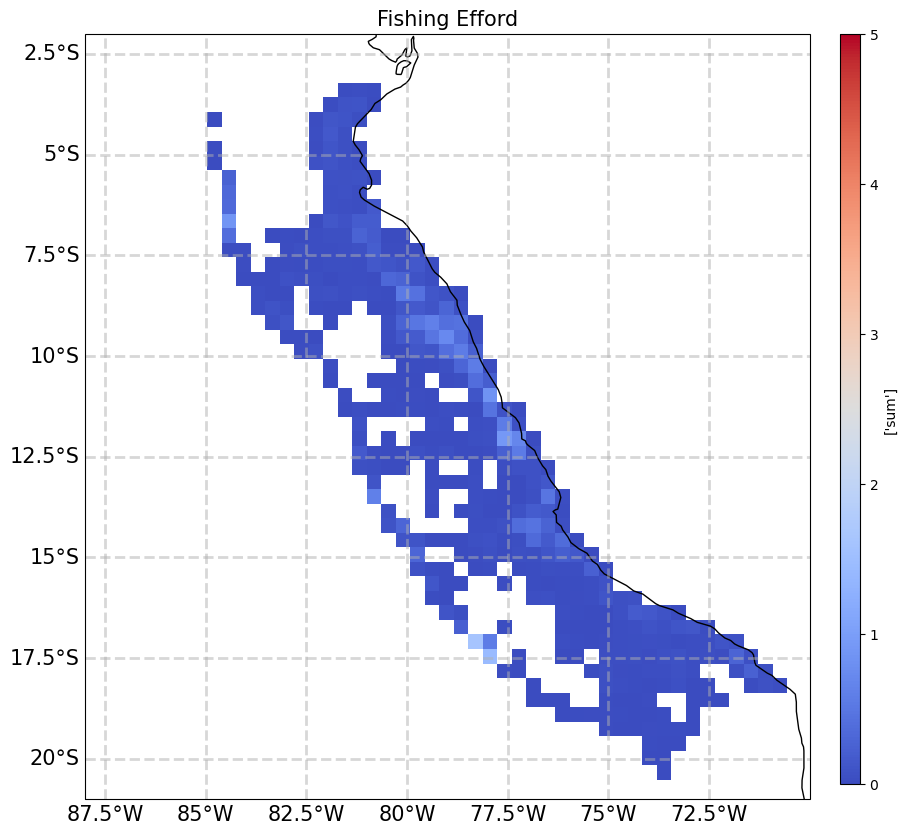

In [19]:
# Visualization parameters
visParams = {'bands': ['sum'],
             'min': 0,
             'max': 5,
            }

fig = plt.figure(figsize=(10, 15))

# create a new Plate-Carree projection 
projection = ccrs.PlateCarree()

# plot the result with cartoee 
ax = cartoee.get_map(effort_EZZ, vis_params=visParams, proj=projection, cmap='coolwarm')

# Define the lon/lat extent of the plot
ax.set_extent([-88,-70,-2,-21])   

# Draw in coastlines
ax.coastlines()

# Draw grid lines
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.5, linestyle='--')

# Set parameters for grid lines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Set plot title
ax.set_title(label='Fishing Efford', fontsize=15)

# Add color bar
cartoee.add_colorbar(ax,visParams,loc="right",cmap='coolwarm')

# Display plot
plt.show()

### Evaluate fishin outside the EEZ

In [27]:
# Setting new AOI including areas beyond the EEZ
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -89.8703470212856,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -2.9010789371311176
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geojson["features"][0]["geometry"]["coordinates"]
aoi = ee.Geometry.Polygon(coords)

# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD') \
    .filterDate('2016-01-01','2017-01-01') \
        .filterBounds(aoi) \
            .map(lambda image: image.clip(aoi));
# Aggregate 2016 collection to single image of global fishing effort
effort_EZZ = effort_all_EEZ.sum();
# Sum bands to get total effort across gear types
effort_EZZ = effort_EZZ.reduce(ee.Reducer.sum());
# Mask out pixels with no effort
effort_EZZ = effort_EZZ.mask(effort_EZZ.gt(0));

# Add the total fishing effort layer
Map5 = geemap.Map(zoom = 2)
Map5.centerObject(aoi, 5)
Map5.setOptions('HYBRID');
Map5.addLayer(aoi, {'color': 'white','width': 1.5}, "EEZ of Perú");
Map5.addLayer(effort_EZZ,trawlersVis2);
Map5

Map(center=[-11.493252083428661, -79.9759195448968], controls=(ZoomControl(options=['position', 'zoom_in_text'…

<a id='usecases'></a> 
### Use Case Examples

This is the "meat" of the notebook, and what will take the majority of the time to present in class. This section should provide:
1) A plain-text summary (1-2 paragraphs) of the use case example you have chosen: include the target users and audience, and potential applicability. 

2) Markdown and code blocks demonstrating how one walks through the desired use case example. This should be similar to the labs we've done in class: you might want to demonstrate how to isolate a particularly interesting time period, then create an image showing a feature you're interested in, for example.

3) A discussion of the results and how they might be extended on further analysis. For example, if there are data quality issues which impact the results, you could discuss how these might be mitigated with additional information/analysis.

Just keep in mind, you'll have roughly 20 minutes for your full presentation, and that goes surprisingly quickly! Probably 2-3 diagnostics is the most you'll be able to get through (you could try practicing with your group members to get a sense of timing).


<a id='binder'></a> 
### Create Binder Environment

The last step is to create a Binder environment for your project, so that we don't have to spend time configuring everyone's environment each time we switch between group presentations. Instructions are below:

 - Assemble all of the data needed in your Github repo: Jupyter notebooks, a README file, and any datasets needed (these should be small, if included within the repo). Larger datasets should be stored on a separate server, and access codes included within the Jupyter notebook as discussed above. 
 
 - Create an _environment_ file: this is a text file which contains information on the packages needed in order to execute your code. The filename should be "environment.yml": an example that you can use for the proper syntax is included in this template repo. To determine which packages to include, you'll probably want to start by displaying the packages loaded in your environment: you can use the command `conda list -n [environment_name]` to get a list.
 
 More information on environment files can be found here:
 https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#

 - Create Binder. Use http://mybinder.org to create a  URL for your notebook Binder (you will need to enter your GitHub repo URL). You can also add a Launch Binder button directly to your GitHub repo, by including the following in your README.md:

```
launch with myBinder
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/<path to your repo>)
```

<a id='references'></a> 
### References

List relevant references. Here are some additional resources on creating professional, shareable notebooks you may find useful:

1. Notebook sharing guidelines from reproducible-science-curriculum: https://reproducible-science-curriculum.github.io/publication-RR-Jupyter/
2. Guide for developing shareable notebooks by Kevin Coakley, SDSC: https://github.com/kevincoakley/sharing-jupyter-notebooks/raw/master/Jupyter-Notebooks-Sharing-Recommendations.pdf
3. Guide for sharing notebooks by Andrea Zonca, SDSC: https://zonca.dev/2020/09/how-to-share-jupyter-notebooks.html
4. Jupyter Notebook Best Practices: https://towardsdatascience.com/jupyter-notebook-best-practices-f430a6ba8c69
5. Introduction to Jupyter templates nbextension: https://towardsdatascience.com/stop-copy-pasting-notebooks-embrace-jupyter-templates-6bd7b6c00b94  
    5.1. Table of Contents (Toc2) readthedocs: https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html  
    5.2. Steps to install toc2: https://stackoverflow.com/questions/23435723/installing-ipython-notebook-table-of-contents
6. Rule A, Birmingham A, Zuniga C, Altintas I, Huang SC, et al. (2019) Ten simple rules for writing and sharing computational analyses in Jupyter Notebooks. PLOS Computational Biology 15(7): e1007007. https://doi.org/10.1371/journal.pcbi.1007007. Supplementary materials: example notebooks (https://github.com/jupyter-guide/ten-rules-jupyter) and tutorial (https://github.com/ISMB-ECCB-2019-Tutorial-AM4/reproducible-computational-workflows)
7. Languages supported by Jupyter kernels: https://github.com/jupyter/jupyter/wiki/Jupyter-kernels
8. EarthCube notebooks presented at EC Annual Meeting 2020: https://www.earthcube.org/notebooks
9. Manage your Python Virtual Environment with Conda: https://towardsdatascience.com/manage-your-python-virtual-environment-with-conda-a0d2934d5195
10. Venv - Creation of Virtual Environments: https://docs.python.org/3/library/venv.html